In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels as sm

from scipy import stats
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, chisquare

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing

import requests

# Pré-processamento

## Dados Clínicos

In [3]:
# Ler ficheiro 'blca_msk_tcga_2020_clinical_data.tsv'
data_bladder = pd.read_csv('blca_msk_tcga_2020_clinical_data.tsv', sep='\t', header=0)
data_bladder.columns = data_bladder.columns.str.replace(' ', '_')                                                               # Substitui espaços por underscores
data_bladder = data_bladder.drop(columns=['Patient_ID', 'Study_ID', 'Cancer_Type', 'Cancer_Type_Detailed', 'Oncotree_Code'])    # Remover colunas desnecessárias/redundantes
data_bladder.set_index('Sample_ID', inplace=True)                                                                               # Definir coluna 'Sample_ID' como indice
data_bladder

FileNotFoundError: [Errno 2] No such file or directory: 'blca_msk_tcga_2020_clinical_data.tsv'

Durante o processo de análise de dados, é comum realizar ajustes na estrutura do conjunto de dados para melhorar sua organização e compreensão. Uma etapa essencial é a verificação da existencia de valores ausentes (NAs) nas colunas. Os NAs podem ocorrer por diversos motivos, como erros de medição ou falhas na coleta de dados, sendo fundamental identificá-los para decidir como tratá-los adequadamente durante a análise. Portanto, após esta etápa, é recomendável realizar uma verificação minuciosa para garantir a integridade dos dados e prepará-los para análises posteriores. Isso contribui para a confiabilidade e qualidade dos resultados obtidos a partir do conjunto de dados.

Os valores de NAs foram substituídos das colunas numéricas pela mediana de cada coluna.

In [ ]:
# Identificar colunas categóricas
categorical_columns = data_bladder.select_dtypes(include=['object']).columns

# Identificar colunas numéricas
numerical_columns = data_bladder.select_dtypes(include=['float64', 'int64']).columns

# Imputar valores NaN nas colunas categóricas com "Unknown"
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
data_bladder[categorical_columns] = categorical_imputer.fit_transform(data_bladder[categorical_columns])

# Imputar valores NaN nas colunas numéricas com a mediana
numerical_imputer = SimpleImputer(strategy='median')
data_bladder[numerical_columns] = numerical_imputer.fit_transform(data_bladder[numerical_columns])

# Verificar o DataFrame atualizado
print(data_bladder)

                 Diagnosis_Age AJCC_Neoplasm_Disease_Stage Analysis_Cohort  \
Sample_ID                                                                    
DS-bla-112                60.0                     Unknown       Discovery   
DS-bla-113                82.0                     Unknown       Discovery   
DS-bla-125                81.0                     Unknown       Discovery   
DS-bla-126                82.0                     Unknown       Discovery   
DS-tur-003-P1             57.0                     Unknown       Discovery   
...                        ...                         ...             ...   
TCGA-ZF-AA56-01           79.0                   STAGE III       Discovery   
TCGA-ZF-AA58-01           61.0                    STAGE IV       Discovery   
TCGA-ZF-AA5H-01           60.0                    STAGE IV       Discovery   
TCGA-ZF-AA5N-01           62.0                    STAGE IV       Discovery   
TCGA-ZF-AA5P-01           65.0                    STAGE IV      

In [ ]:
# Imprimir os valores e suas ocorrências para cada coluna categórica
for col in categorical_columns:
    print(f"Contagem de valores para a coluna: {col}")
    print(data_bladder[col].value_counts())
    print("\n")

Contagem de valores para a coluna: AJCC_Neoplasm_Disease_Stage
AJCC_Neoplasm_Disease_Stage
Unknown      177
STAGE III    103
STAGE IV     100
STAGE II      96
Name: count, dtype: int64


Contagem de valores para a coluna: Analysis_Cohort
Analysis_Cohort
Discovery     384
Validation     92
Name: count, dtype: int64


Contagem de valores para a coluna: Cohort
Cohort
TCGA                      300
Chemo NaÃ¯ve 12245 DMP     92
XRT MSK                    42
ERCC2 Platinum             34
Eur Urol 2013 BCa           4
Progression Series          2
Oscar Lin                   2
Name: count, dtype: int64


Contagem de valores para a coluna: Disease_Free_Status
Disease_Free_Status
Unknown                  329
0:DiseaseFree            121
1:Recurred/Progressed     26
Name: count, dtype: int64


Contagem de valores para a coluna: Distant_Metastasis
Distant_Metastasis
Unknown    280
Mx         147
Yes         49
Name: count, dtype: int64


Contagem de valores para a coluna: Ethnicity_Category
Ethni

De forma a verificar se a substituição dos NAs correu bem verificamos se alguma das colunas tem valores ausentes.

In [ ]:
data_bladder.isna().sum() # Verificar se alguma das colunas tem valores ausentes

Diagnosis_Age                             0
AJCC_Neoplasm_Disease_Stage               0
Analysis_Cohort                           0
Aneuploidy_Score                          0
Buffa_Hypoxia_Score                       0
Cohort                                    0
Disease_Free_(Months)                     0
Disease_Free_Status                       0
Distant_Metastasis                        0
Ethnicity_Category                        0
Fraction_Genome_Altered                   0
Neoplasm_Histologic_Grade                 0
Lymph_Node_Status                         0
MSI_MANTIS_Score                          0
MSIsensor_Score                           0
Mutation_Count                            0
Overall_Survival_(Months)                 0
Overall_Survival_Status                   0
AJCC_Metastasis_Stage_Code                0
AJCC_Neoplasm_Disease_Lymph_Node_Stage    0
AJCC_Tumor_Stage_Code                     0
Progress_Free_Survival_(Months)           0
Progression_Free_Status         

In [ ]:
data_bladder.info() # Verificar tipos de colunas e outras informações gerais sobre o DataFrame

<class 'pandas.core.frame.DataFrame'>
Index: 476 entries, DS-bla-112 to TCGA-ZF-AA5P-01
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Diagnosis_Age                           476 non-null    float64
 1   AJCC_Neoplasm_Disease_Stage             476 non-null    object 
 2   Analysis_Cohort                         476 non-null    object 
 3   Aneuploidy_Score                        476 non-null    float64
 4   Buffa_Hypoxia_Score                     476 non-null    float64
 5   Cohort                                  476 non-null    object 
 6   Disease_Free_(Months)                   476 non-null    float64
 7   Disease_Free_Status                     476 non-null    object 
 8   Distant_Metastasis                      476 non-null    object 
 9   Ethnicity_Category                      476 non-null    object 
 10  Fraction_Genome_Altered                 476 no

In [ ]:
data_bladder.describe() # Verificar as estatísticas descritivas das colunas numéricas

,Diagnosis_Age,Aneuploidy_Score,Buffa_Hypoxia_Score,Disease_Free_(Months),Fraction_Genome_Altered,MSI_MANTIS_Score,MSIsensor_Score,Mutation_Count,Overall_Survival_(Months),Progress_Free_Survival_(Months),Ragnum_Hypoxia_Score,Number_of_Samples_Per_Patient,TMB_(nonsynonymous),Winter_Hypoxia_Score
count,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.0,476.000000,476.000000
mean,67.382439,13.722689,13.642857,23.999530,0.262737,0.324647,0.248992,181.403361,27.876030,21.355608,11.525210,1.0,9.070931,19.537815
std,10.724791,6.258871,14.259496,18.331331,0.188967,0.014189,1.137953,281.520236,26.391757,22.629639,8.272809,0.0,12.263071,19.555175
min,31.210959,0.000000,-39.000000,0.000000,0.000000,0.223600,0.000000,1.000000,0.000000,0.000000,-20.000000,1.0,0.000000,-38.000000
25%,60.000000,11.000000,9.000000,20.054575,0.096675,0.321775,0.000000,22.000000,12.098498,12.024526,10.000000,1.0,2.800000,11.500000
50%,67.000000,14.000000,13.000000,20.054575,0.242950,0.325450,0.050000,107.000000,18.575139,15.336818,13.000000,1.0,5.872318,18.000000
75%,76.000000,16.000000,19.000000,20.054575,0.394400,0.329000,0.160000,227.000000,34.833110,18.813492,16.000000,1.0,10.765917,24.000000
max,90.000000,34.000000,49.000000,163.296841,0.945500,0.414300,22.700000,3548.000000,166.025578,163.296841,28.000000,1.0,134.207791,76.000000


### API cBioPortal

In [ ]:
# Base URL da API do cBioPortal
BASE_URL = "https://www.cbioportal.org/api"

# Função para obter metadados clínicos de um estudo específico
def get_clinical_metadata(study_id):
    endpoint = f"{BASE_URL}/studies/{study_id}/clinical-attributes"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()
    else:
        response.raise_for_status()

In [ ]:
# Especificar o ID do estudo
study_id = 'blca_msk_tcga_2020'

# Obter metadados clínicos para o estudo especificado
clinical_metadata = get_clinical_metadata(study_id)
print("Número de atributos clínicos:", len(clinical_metadata))

# Converter metadados clínicos em um DataFrame do pandas
metadata_df = pd.DataFrame(clinical_metadata)

# Exibir os primeiros registros dos metadados
print("Metadados clínicos:")
print(metadata_df.head())

# Exibir os nomes dos atributos clínicos
print("Lista de atributos clínicos:")
print(metadata_df['clinicalAttributeId'].tolist())

Número de atributos clínicos: 40
Metadados clínicos:
                   displayName  \
0                Diagnosis Age   
1  AJCC Neoplasm Disease Stage   
2              Analysis Cohort   
3             Aneuploidy Score   
4          Buffa Hypoxia Score   

                                         description datatype  \
0  Age at which a condition or disease was first ...   NUMBER   
1  The extent of a cancer, especially whether the...   STRING   
2                                    Analysis Cohort   STRING   
3                                   Aneuploidy Score   NUMBER   
4  Hypoxia scores based on the Buffa mRNA abundan...   NUMBER   

   patientAttribute priority          clinicalAttributeId             studyId  
0              True        1                          AGE  blca_msk_tcga_2020  
1              True        1  AJCC_PATHOLOGIC_TUMOR_STAGE  blca_msk_tcga_2020  
2             False        1              ANALYSIS_COHORT  blca_msk_tcga_2020  
3             False        1   

In [ ]:
# Iterar a descrição de cada atributo clínico (colunas do dataset)
for index, row in metadata_df.iterrows():
    clinical_attribute_id = row['clinicalAttributeId']
    description = row['description']
    print(f"{clinical_attribute_id.ljust(metadata_df['clinicalAttributeId'].str.len().max())} \t {description}")

AGE                             	 Age at which a condition or disease was first diagnosed.
AJCC_PATHOLOGIC_TUMOR_STAGE     	 The extent of a cancer, especially whether the disease has spread from the original site to other parts of the body based on AJCC staging criteria.
ANALYSIS_COHORT                 	 Analysis Cohort
ANEUPLOIDY_SCORE                	 Aneuploidy Score
BUFFA_HYPOXIA_SCORE             	 Hypoxia scores based on the Buffa mRNA abundance signatures
CANCER_TYPE                     	 Cancer Type
CANCER_TYPE_DETAILED            	 Cancer Type Detailed
COHORT                          	 Cohort
DFS_MONTHS                      	 Disease free (months) since initial treatment.
DFS_STATUS                      	 Disease free status since initial treatment.
DISTANT_METS                    	 Distant Metastasis
ETHNICITY                       	 The text for reporting information about ethnicity.
FRACTION_GENOME_ALTERED         	 Fraction Genome Altered
GRADE                           	

## mRNA Seq

In [ ]:
# Ler o ficheiro data_mrna_seq_v2_rsem.txt
data_mrnaseq = pd.read_csv('blca_msk_tcga_2020/data_mrna_seq_v2_rsem.txt', delimiter='\t')
data_mrnaseq = data_mrnaseq.dropna(subset=['Hugo_Symbol'])      # Remover linhas onde valor na coluna 'Hugo_Symbol' é NaN
data_mrnaseq = data_mrnaseq.drop(columns=['Entrez_Gene_Id'])    # Remover coluna 'Entrez_Gene_Id'
data_mrnaseq.set_index('Hugo_Symbol', inplace=True)             # Definir 'Hugo_Symbol' como indice
data_mrnaseq

,TCGA-2F-A9KP-01,TCGA-2F-A9KQ-01,TCGA-2F-A9KR-01,TCGA-2F-A9KT-01,TCGA-2F-A9KW-01,TCGA-4Z-AA7O-01,TCGA-4Z-AA7Q-01,TCGA-4Z-AA7S-01,TCGA-4Z-AA7Y-01,TCGA-4Z-AA80-01,...,TCGA-ZF-AA4X-01,TCGA-ZF-AA51-01,TCGA-ZF-AA52-01,TCGA-ZF-AA53-01,TCGA-ZF-AA54-01,TCGA-ZF-AA56-01,TCGA-ZF-AA58-01,TCGA-ZF-AA5H-01,TCGA-ZF-AA5N-01,TCGA-ZF-AA5P-01
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
UBE2Q2P2,12.5759,10.7742,42.5810,17.6427,2.3091,8.665,11.9205,13.7922,17.5126,14.1017,...,10.3812,5.2751,14.5465,6.8871,8.0213,7.8474,2.0911,1.1387,0.0000,4.0856
HMGB1P1,137.8860,104.6780,146.4530,142.9620,176.8770,179.199,96.9139,131.3010,175.6810,167.6800,...,58.4972,119.0880,91.4959,163.8500,83.2794,185.6730,210.1810,186.9380,155.3010,114.1130
RNU12-2P,0.8323,0.0000,2.3743,0.0000,0.0000,0.000,0.0000,0.4576,0.0000,0.0000,...,2.0010,0.0000,0.0000,0.0000,0.5061,0.0000,0.0000,0.0000,1.2270,0.5559
SSX9P,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,7.2848,0.0000,0.0000,7.7482,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
EZHIP,0.0000,0.0000,1.8995,5.0876,0.5236,0.000,19.2053,0.0000,0.0000,2.4213,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4216,0.6470,0.0000,4.4469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,17.0620,1.8544,1.8995,6.7835,51.3143,0.000,15.2318,3.6608,11.0142,5.8111,...,23.6118,11.3037,1.7668,36.5014,94.1296,2.2056,143.3390,0.3235,15.9509,13.3407
ZYG11B,1526.4300,1571.1600,748.8600,878.4620,1493.8700,870.490,615.8940,1285.4100,967.8750,876.0290,...,1311.4600,1003.7700,624.2640,431.1300,523.2790,697.8390,711.2140,671.9240,358.2820,887.7150
ZYX,3105.2900,3275.3800,4465.6200,3449.4100,2778.3000,4226.770,5065.5600,3836.5600,3156.9500,2389.8300,...,2098.6500,2724.9400,6375.7400,11268.6000,7956.4800,5666.0800,9911.0500,9212.5000,6306.7500,14836.0000


In [ ]:
data_mrnaseq.rename_axis('', inplace=True)  # Remove o nome 'Hugo_Symbol' do índice
data_mrnaseq = data_mrnaseq.transpose()     # Faz a transposta do dataframe (NOTA: correr este código novamente reverte a transposta, se se enganar no código, corre a leitura do 'data_mrnaseq' primeiro!!!)
data_mrnaseq

,UBE2Q2P2,HMGB1P1,RNU12-2P,SSX9P,EZHIP,EFCAB8,SRP14P1,TRIM75P,SPATA31B1P,REXO1L6P,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-2F-A9KP-01,12.5759,137.886,0.8323,0.0,0.0000,4.5776,2.0807,0.4161,0.0,0.0,...,718.119,969.621,37.0370,316.688,1420.720,17.0620,1526.430,3105.29,1467.750,860.591
TCGA-2F-A9KQ-01,10.7742,104.678,0.0000,0.0,0.0000,0.4636,2.3180,0.0000,0.0,0.0,...,532.536,795.086,60.2689,378.303,873.435,1.8544,1571.160,3275.38,750.580,621.233
TCGA-2F-A9KR-01,42.5810,146.453,2.3743,0.0,1.8995,1.4246,3.7989,0.0000,0.0,0.0,...,616.848,568.412,45.5869,470.115,1924.150,1.8995,748.860,4465.62,910.788,935.481
TCGA-2F-A9KT-01,17.6427,142.962,0.0000,0.0,5.0876,2.2612,6.2182,0.0000,0.0,0.0,...,726.625,1087.050,17.5240,281.515,938.383,6.7835,878.462,3449.41,850.198,630.865
TCGA-2F-A9KW-01,2.3091,176.877,0.0000,0.0,0.5236,1.5708,5.7598,0.0000,0.0,0.0,...,421.714,2055.190,25.6571,244.005,1160.330,51.3143,1493.870,2778.30,2811.290,746.151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZF-AA56-01,7.8474,185.673,0.0000,0.0,0.0000,0.0000,3.0878,0.0000,0.0,0.0,...,551.566,1201.150,22.4967,220.997,745.038,2.2056,697.839,5666.08,752.977,619.321
TCGA-ZF-AA58-01,2.0911,210.181,0.0000,0.0,0.4216,1.2648,1.2648,0.0000,0.0,0.0,...,532.618,1059.440,37.5211,254.637,1037.100,143.3390,711.214,9911.05,745.363,548.904
TCGA-ZF-AA5H-01,1.1387,186.938,0.0000,0.0,0.6470,14.8813,2.9116,0.0000,0.0,0.0,...,520.105,1248.410,19.0869,186.663,498.200,0.3235,671.924,9212.50,911.319,1053.660
TCGA-ZF-AA5N-01,0.0000,155.301,1.2270,0.0,0.0000,2.4540,1.2270,0.0000,0.0,0.0,...,496.638,641.718,13.4969,121.472,534.969,15.9509,358.282,6306.75,850.307,380.368


Reparamos que 'data_bladder' tem dimensões (476, 37) e data_mrnaseq tem dimensões (296, 20518) depois de ter sido transposta. Considerando que em ambos os dataframes o índice trata-se dos Sample_IDs, e que queremos associar os valores entre os dois dataframes, vamos tentar igualar o número de linhas que cada dataset tem, por este modo, criamos um novo dataframe 'data_bladder_new' que irá ter os mesmos valores de índice (Sample_ID) que em 'data_mrnaseq'. Deste modo, podemos associar os valores e as colunas entres os dois dataframes:

In [ ]:
data_bladder_index = data_bladder.index                                         # Obter os índices de data_mrnaseq e data
data_bladder_new = data_bladder[data_bladder_index.isin(data_mrnaseq.index)]    # Filtrar 'data' para só ter as linhas que também existem em 'data_mrnaseq'
data_bladder_new.shape

(296, 37)

## PCA

A Análise de Componentes Principais (PCA) é uma técnica de redução de dimensionalidade amplamente utilizada em análise de dados e machine learning.

In [ ]:
pca = PCA(n_components=20)
X_r = pca.fit(data_mrnaseq).transform(data_mrnaseq)

In [ ]:
# Normalização dos dados
scaler = StandardScaler()
data_mrnaseq_normalized = scaler.fit_transform(data_mrnaseq)

# Aplicação do PCA nos dados normalizados
pca = PCA(n_components=24)
X_r = pca.fit_transform(data_mrnaseq_normalized)

In [ ]:
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.sum()

[0.0659697  0.06398258 0.0370354  0.03069887 0.02325094 0.01902873
 0.01605018 0.0151707  0.01292005 0.01279023 0.0119993  0.01152316
 0.01127753 0.01062819 0.01000873 0.00937256 0.00932252 0.00898259
 0.0086433  0.008417   0.00796886 0.00764236 0.00747265 0.00727165]


0.4274277868637148

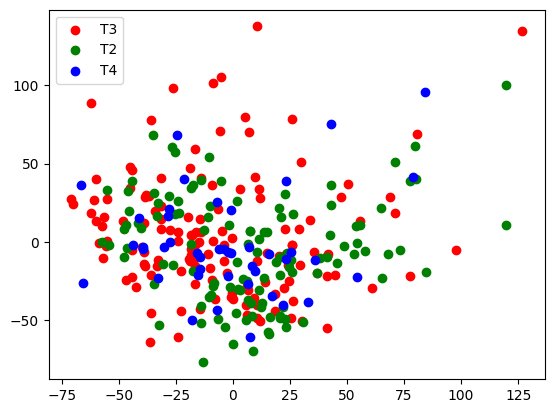

In [ ]:
meta_var = data_bladder_new.loc[:,"Tumor_Stage"]
meta_values = meta_var.unique()

plt.figure()
for c, name in zip("rgby", meta_values):
    plt.scatter(X_r[meta_var == name, 0], X_r[meta_var == name, 1], c=c, label=name)
plt.legend()
plt.show()

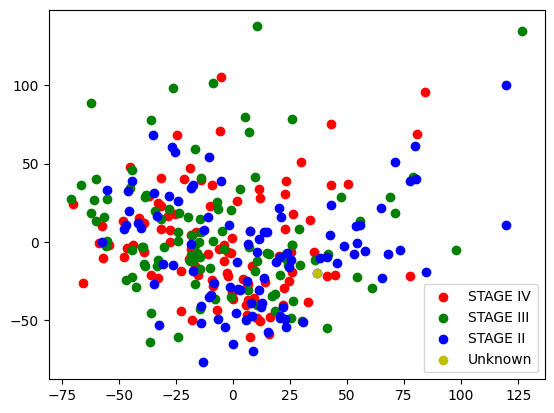

In [ ]:
meta_var = data_bladder_new.loc[:,"AJCC_Neoplasm_Disease_Stage"]
meta_values = meta_var.unique()

plt.figure()
for c, name in zip("rgby", meta_values):
    plt.scatter(X_r[meta_var == name, 0], X_r[meta_var == name, 1], c=c, label=name)
plt.legend()
plt.show()

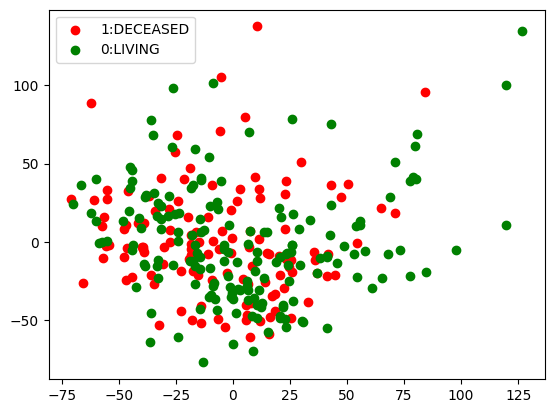

In [ ]:
meta_var = data_bladder_new.loc[:,"Overall_Survival_Status"]
meta_values = meta_var.unique()

plt.figure()
for c, name in zip("rgby", meta_values):
    plt.scatter(X_r[meta_var == name, 0], X_r[meta_var == name, 1], c=c, label=name)
plt.legend()
plt.show()

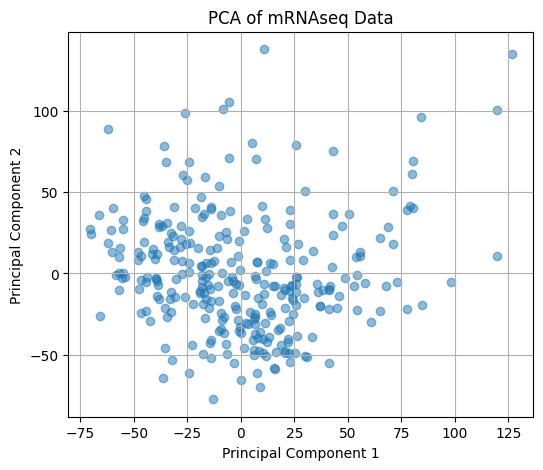

In [ ]:
plt.figure(figsize=(6, 5))
plt.scatter(X_r[:, 0], X_r[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of mRNAseq Data')
plt.grid(True)
plt.show()

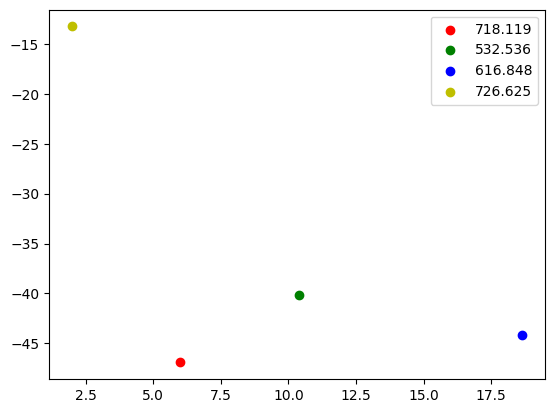

In [ ]:
meta_var = data_mrnaseq.loc[:,"ZWILCH"]
meta_values = meta_var.unique()

plt.figure()
for c, name in zip("rgby", meta_values):
    plt.scatter(X_r[meta_var == name, 0], X_r[meta_var == name, 1], c=c, label=name)
plt.legend()
plt.show()
# conseguindo perceber que não existe uma diferenciação claras entre os diferentes estadios
#grafico score plot....novo posicionamento após realização de PCA
# ateves da analise do graffico não é posivel

# Machine Learning

Machine learning é um campo da ciência da computação onde programas de computador aprendem e melhoram a execução de tarefas específicas, através da análise e interpretação de dados (experiência E), dentro de uma classe de tarefas definida (T), com o objetivo de otimizar uma medida de desempenho (P). Essa definição, proposta por Mitchell em 1997, tem sido fundamental para o desenvolvimento de modelos e algoritmos utilizados na Mineração de Dados, contribuindo significativamente para diversas aplicações práticas.

## KMeans
A função objetiva do K-means é minimizar a WSS (Within-Cluster Sum of Squared Errors), que mede a compactação dos clusters.


[5741238.712786719, 5599959.443634573, 5365539.277744727, 5371080.135809888, 5234121.070284239, 5185425.13116336, 5146310.354243806, 5083760.602366504, 5111972.750991299]


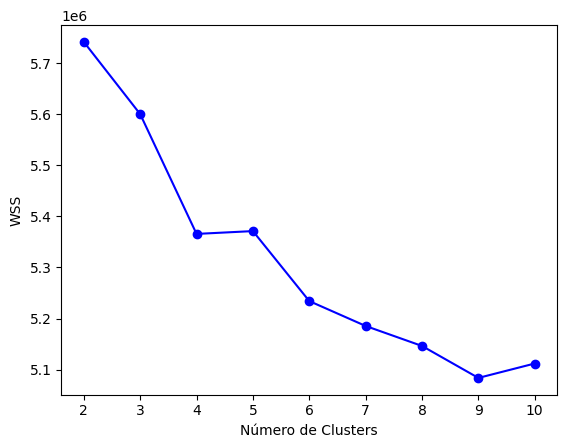

In [ ]:
# Escalar os dados de expressão génica para normalizar (padronizar) as características
data_mrnaseq_proc = preprocessing.scale(data_mrnaseq)

# Inicializar uma lista para armazenar os valores da soma das distâncias quadráticas dentro dos clusters (WSS)
ofs = []

# Ciclo para calcular a WSS para diferentes números de clusters, de 2 a 10
for k in range(2, 11):
    # Criar uma instância do modelo K-means com k clusters
    kmeans = KMeans(n_clusters=k, n_init="auto")
    # Ajustar o modelo aos dados escalados
    kmeans.fit(data_mrnaseq_proc)
    # Adicionar o valor da inércia (WSS) à lista
    ofs.append(kmeans.inertia_)

# Imprimir a lista de valores da WSS para cada número de clusters
print(ofs)

# Plotar os valores da WSS em função do número de clusters
plt.plot(range(2, 11), ofs, 'b-o')
plt.xlabel('Número de Clusters')
plt.ylabel('WSS')
plt.show()

Agora com recurso ao algoritmo K-means, agrupamos os dados de expressão genética em 4 clusters, em seguida, examinamos como esses clusters se relacionam com o estado geral de sobrevivência dos pacientes. 
A matriz de confusão resultante fornece insights sobre como os padrões de expressão genética podem estar associados à sobrevivência dos pacientes em diferentes grupos de clusters.

In [ ]:
kmeans3 = KMeans(n_clusters=4, n_init="auto")

res_kmeans = kmeans3.fit(data_mrnaseq_proc).predict(data_mrnaseq_proc)
pd.crosstab(data_bladder_new.loc[:, "Overall_Survival_Status"], res_kmeans)


col_0,0,1,2,3
Overall_Survival_Status,,,,
0:LIVING,1,57,76,39
1:DECEASED,0,51,52,20


In [ ]:
# realizamos o mesmo processo para AJCC_Neoplasm_Disease_Stage
kmeans4 = KMeans(n_clusters=4, n_init = "auto")
res_kmeans = kmeans4.fit(data_mrnaseq_proc).predict(data_mrnaseq_proc)

pd.crosstab(data_bladder_new.loc[:,"AJCC_Neoplasm_Disease_Stage"], res_kmeans)

col_0,0,1,2,3
AJCC_Neoplasm_Disease_Stage,,,,
STAGE II,0,68,5,22
STAGE III,1,45,21,35
STAGE IV,0,56,14,28
Unknown,0,1,0,0


In [ ]:
# realizamos o mesmo processo para AJCC_Neoplasm_Disease_Stage
kmeans5 = KMeans(n_clusters=4, n_init = "auto")
res_kmeans = kmeans5.fit(data_mrnaseq_proc).predict(data_mrnaseq_proc)

pd.crosstab(data_bladder_new.loc[:,"Tumor_Stage"], res_kmeans)

col_0,0,1,2,3
Tumor_Stage,,,,
T2,2,11,37,65
T3,9,16,64,49
T4,4,4,16,19


Na proxima etápa filtramos as colunas do DataFrame data_mrnaseq para manter apenas aquelas com alta variabilidade interquartil, eliminando as colunas com menor variabilidade. Isso ajuda a focar nas colunas que têm maior variação, que podem ser mais informativas para análises subsequentes.

In [ ]:
Q1 = data_mrnaseq.quantile(0.25)
Q3 = data_mrnaseq.quantile(0.75)
iqr = Q3 - Q1
cutoff = iqr.quantile(0.2)
filtered_columns = iqr[iqr > cutoff].index 
filtered_data = data_mrnaseq[filtered_columns]
filtered_data.shape

(296, 16423)

Selecionamos os genes que estão mais fortemente associados com o estágio do tumor e identifica aqueles com uma expressão diferencial estatisticamente significativa (p-valor < 0.001). A seleção é baseada numa análise ANOVA e os resultados ajudam a destacar genes potencialmente importantes para o estudo do estágio do tumor.

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=10)

selector.fit_transform(filtered_data, data_bladder_new.loc[:,"Tumor_Stage"])
gde = np.where(selector.pvalues_ <0.001) # espressão diferencial de genes
print(filtered_data.columns[gde])

Index(['ACADVL', 'ACYP2', 'ADAM12', 'ADAMTS2', 'ADAMTS4', 'ADC', 'ADRA2A',
       'AEBP1', 'AFAP1', 'AGAP8',
       ...
       'ZBTB9', 'ZCCHC10', 'ZEB1', 'ZEB2', 'ZNF211', 'ZNF266', 'ZNF385A',
       'ZNF440', 'ZNF469', 'ZNF521'],
      dtype='object', name='', length=347)


Realizamos o mesmo processo mas deta vez com um critério de p-valor menor que 0.05. 
Ao ajustarmos o limite de p-valor para 0.05, o código permite a inclusão de mais genes potencialmente relevantes para a análise do estágio do tumor, fornecendo uma visão mais ampla dos genes que podem estar envolvidos.

In [ ]:
gde2 = np.where(selector.pvalues_ <0.05)
print(filtered_data.columns[gde2])

Index(['UBE2Q2P2', 'SRP14P1', 'A2M', 'A2ML1', 'AAAS', 'AADAC', 'AADAT', 'AARS',
       'AARS2', 'AATF',
       ...
       'ZNF841', 'ZNF860', 'ZNF91', 'ZPLD1', 'ZRANB3', 'ZSWIM3', 'ZSWIM4',
       'ZSWIM6', 'ZUFSP', 'ZYX'],
      dtype='object', name='', length=2748)


Realizamos o mesmo processo para selecionar os genes que estão mais fortemente associados com o estado geral de sobrevivência dos pacientes e identifica aqueles com uma expressão diferencial estatisticamente significativa (p-valor < 0.001).

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=10)

selector.fit_transform(filtered_data, data_bladder_new.loc[:,"Overall_Survival_Status"])
gde = np.where(selector.pvalues_ <0.001) # espressão diferencial de genes
print(filtered_data.columns[gde])

Index(['ABT1', 'AHNAK', 'AKAP7', 'APOBEC3D', 'APOL1', 'APOL2', 'BAIAP2',
       'BAT1', 'BCL2L14', 'C19orf71',
       ...
       'TRIM26', 'TRIM27', 'TRIM38', 'TTLL3', 'WWTR1', 'ZBTB49', 'ZFYVE27',
       'ZHX3', 'ZNF193', 'ZNF195'],
      dtype='object', name='', length=112)


Realizamos o mesmo processo para selecionar os genes que estão mais fortemente associados com cada o estadío da doença neoplásica AJCC e identifica aqueles com uma expressão diferencial estatisticamente significativa (p-valor < 0.001).

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=10)

selector.fit_transform(filtered_data, data_bladder_new.loc[:,"AJCC_Neoplasm_Disease_Stage"])
gde = np.where(selector.pvalues_ <0.001) # espressão diferencial de genes
print(filtered_data.columns[gde])

Index(['ACIN1', 'ACYP2', 'ADAM12', 'ADAMTS2', 'AEBP1', 'AFAP1', 'AGAP8',
       'AGR2', 'AIG1', 'AKAP7',
       ...
       'ZNF384', 'ZNF385A', 'ZNF432', 'ZNF440', 'ZNF521', 'ZNF69', 'ZNF700',
       'ZNF841', 'ZNF90', 'ZNRD1'],
      dtype='object', name='', length=422)


Filtramos os dados de expressão gênica processados para manter apenas as características (genes) que foram selecionadas como estatisticamente significativas em relação ao estadío da doença neoplásica AJCC. Isso ajuda a reduzir a dimensionalidade dos dados para as características mais relevantes, simplificando a análise e potencialmente melhorando a capacidade de predição ou entendimento dos dados.

In [ ]:
data_mrnaseq_proc_filt = data_mrnaseq_proc[:,gde[0]]
data_mrnaseq_proc_filt.shape

(296, 422)

Nesta etapa dividimos os dados de expressão genética filtrados em conjuntos de treino e teste, bem como suas variáveis alvo correspondentes, para uso em um modelo de machine learning. Essa divisão é fundamental para avaliar o desempenho do modelo em dados novos e evitar overfitting.

In [ ]:
output_canc = data_bladder_new.loc[:,"Tumor_Stage"]

indices = np.random.permutation(len(data_mrnaseq_proc_filt))
numts = int(1/3 * data_mrnaseq_proc_filt.shape[0])
train_in = data_mrnaseq_proc_filt[indices[:-numts]]
train_out = output_canc[indices[:-numts]]
test_in  = data_mrnaseq_proc_filt[indices[-numts:]]
test_out = output_canc[indices[-numts:]]
train_in.shape, train_out.shape, test_in.shape, test_out.shape

C:\Users\tiago\AppData\Local\Temp\ipykernel_20836\1208520294.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_out = output_canc[indices[:-numts]]
C:\Users\tiago\AppData\Local\Temp\ipykernel_20836\1208520294.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_out = output_canc[indices[-numts:]]


((198, 422), (198,), (98, 422), (98,))

In [ ]:
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score

tree_model = tree.DecisionTreeClassifier()
tree_model = tree_model.fit(train_in, train_out)
preds_tree = tree_model.predict(test_in)

print(confusion_matrix(test_out, preds_tree) )
print(accuracy_score(test_out, preds_tree))

[[18 19  4]
 [ 8 26  8]
 [ 3 11  1]]
0.45918367346938777


Por fim avaliamos o desempenho dos dois modelos de Machine Learning (árvore de decisão e SVM) na classificação dos dados de expressão genética, utilizando validação cruzada para uma avaliação mais robusta. 
O desempenho é medido pela accuracy média obtida ao longo das dobras de validação cruzada para cada modelo. Isso permite comparar objetivamente o desempenho dos modelos na tarefa de classificação dos dados de expressão gênica em relação ao estágio do cancro.

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

scores_tree = cross_val_score(tree_model, data_mrnaseq_proc_filt, output_canc, cv = 5)
print(scores_tree.mean())

model_svm = svm.SVC(gamma=0.001, C=100.)
scores_svm = cross_val_score(model_svm, data_mrnaseq_proc_filt, output_canc, cv = 5)
print(scores_svm.mean())

0.39519774011299436
0.5001694915254238
